2.4.9.1
>> Downloading inception-2015-12-05.tgz 27.6%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.


>> Downloading inception-2015-12-05.tgz 73.0%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.


>> Downloading inception-2015-12-05.tgz 100.0%
Succesfully downloaded inception-2015-12-05.tgz 88931400 bytes.


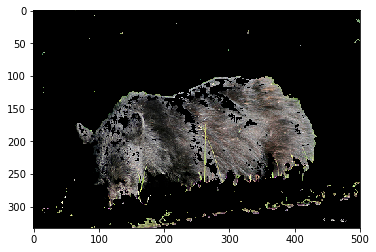

AttributeError: 'module' object has no attribute 'connectedComponentsWithStats'

In [1]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Simple image classification with Inception.

Run image classification with Inception trained on ImageNet 2012 Challenge data
set.

This program creates a graph from a saved GraphDef protocol buffer,
and runs inference on an input JPEG image. It outputs human readable
strings of the top 5 predictions along with their probabilities.

Change the --image_file argument to any jpg image to compute a
classification of that image.

Please see the tutorial and website for a detailed description of how
to use this script to perform image recognition.

https://tensorflow.org/tutorials/image_recognition/
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os.path
import re
import sys
import tarfile
import cv2
print(cv2.__version__)

import numpy as np
from six.moves import urllib
import tensorflow as tf

import time
import subprocess
import os.path
import matplotlib.pyplot as plt
%matplotlib inline

#### support quntization ops ####
#from tensorflow.contrib.quantization import load_quantized_ops_so
#from tensorflow.contrib.quantization.kernels import load_quantized_kernels_so
#load_quantized_ops_so.Load()
#load_quantized_kernels_so.Load()
#################################

FLAGS = tf.app.flags.FLAGS

sum1 = 0
sum2 = 0
count = 1
count1 = 1
value = 0



# classify_image_graph_def.pb:
#   Binary representation of the GraphDef protocol buffer.
# imagenet_synset_to_human_label_map.txt:
#   Map from synset ID to a human readable string.
# imagenet_2012_challenge_label_map_proto.pbtxt:
#   Text representation of a protocol buffer mapping a label to synset ID.
tf.app.flags.DEFINE_string(
    'model_dir', '/bear_detection/imagenet',
    """Path to classify_image_graph_def.pb, """
    """imagenet_synset_to_human_label_map.txt, and """
    """imagenet_2012_challenge_label_map_proto.pbtxt.""")
tf.app.flags.DEFINE_string('image_file', '',
                           """Absolute path to image file.""")
tf.app.flags.DEFINE_integer('num_top_predictions', 5,
                            """Display this many predictions.""")

# pylint: disable=line-too-long
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
# pylint: enable=line-too-long



def GetCpuStat():
    Cmd = 'cat /proc/stat | grep cpu'
    result = subprocess.Popen(Cmd, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
    Rstdout ,Rstderr = result.communicate()
    LineList = Rstdout.splitlines()
    #
    TckList = []
    for Line in LineList:
        ItemList = Line.split()
        TckIdle = int(ItemList[4])
        TckBusy = int(ItemList[1])+int(ItemList[2])+int(ItemList[3])
        TckAll  = TckBusy + TckIdle
        TckList.append( [ TckBusy ,TckAll ] )
    return  TckList
 
class CpuUsage:
    def __init__(self):
        self._TckList    = GetCpuStat()
 
    def get(self):
        TckListPre       = self._TckList
        TckListNow       = GetCpuStat()
        self._TckList    = TckListNow
        CpuRateList = []
        for (TckNow, TckPre) in zip(TckListNow, TckListPre):
            TckDiff = [ Now - Pre for (Now , Pre) in zip(TckNow, TckPre) ]
            TckBusy = TckDiff[0]
            TckAll  = TckDiff[1]
            CpuRate = int(TckBusy*100/TckAll)
            CpuRateList.append( CpuRate )
        return CpuRateList
    
    




class NodeLookup(object):
    
    """Converts integer node ID's to human readable labels."""
    def __init__(self,
               label_lookup_path=None,
               uid_lookup_path=None):
        if not label_lookup_path:
            label_lookup_path = os.path.join(
                FLAGS.model_dir, 'imagenet_2012_challenge_label_map_proto.pbtxt')
        if not uid_lookup_path:
            uid_lookup_path = os.path.join(
                FLAGS.model_dir, 'imagenet_synset_to_human_label_map.txt')
        self.node_lookup = self.load(label_lookup_path, uid_lookup_path)

    def load(self, label_lookup_path, uid_lookup_path):
        
        """Loads a human readable English name for each softmax node.
        
        Args:
        label_lookup_path: string UID to integer node ID.
        uid_lookup_path: string UID to human-readable string.
        Returns:
        dict from integer node ID to human-readable string.
        """
        if not tf.gfile.Exists(uid_lookup_path):
            tf.logging.fatal('File does not exist %s', uid_lookup_path)
        if not tf.gfile.Exists(label_lookup_path):
            tf.logging.fatal('File does not exist %s', label_lookup_path)

        # Loads mapping from string UID to human-readable string
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human = {}
        p = re.compile(r'[n\d]*[ \S,]*')
        for line in proto_as_ascii_lines:
            parsed_items = p.findall(line)
            uid = parsed_items[0]
            human_string = parsed_items[2]
            uid_to_human[uid] = human_string
            
        # Loads mapping from string UID to integer node ID.
        node_id_to_uid = {}
        proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        for line in proto_as_ascii:
            if line.startswith('  target_class:'):
                target_class = int(line.split(': ')[1])
            if line.startswith('  target_class_string:'):
                target_class_string = line.split(': ')[1]
                node_id_to_uid[target_class] = target_class_string[1:-2]
        
        # Loads the final mapping of integer node ID to human-readable string
        node_id_to_name = {}
        for key, val in node_id_to_uid.items():
            if val not in uid_to_human:
                tf.logging.fatal('Failed to locate: %s', val)
            name = uid_to_human[val]
            node_id_to_name[key] = name

        return node_id_to_name

    def id_to_string(self, node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]


def create_graph():
    
    """Creates a graph from saved GraphDef file and returns a saver."""
    # Creates graph from saved graph_def.pb.
    with tf.gfile.FastGFile(os.path.join(
        FLAGS.model_dir, 'classify_image_graph_def.pb'), 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')


def run_inference_on_image(image):
    
    """Runs inference on an image.

    Args:
    image: Image file name.

    Returns:
    Nothing
    """
    if not tf.gfile.Exists(image):
        tf.logging.fatal('File does not exist %s', image)
    image_data = tf.gfile.FastGFile(image, 'rb').read()


    # Creates graph from saved GraphDef.
    #create_graph()

    with tf.Session() as sess:
        # Some useful tensors:
        # 'softmax:0': A tensor containing the normalized prediction across
        #   1000 labels.
        # 'pool_3:0': A tensor containing the next-to-last layer containing 2048
        #   float description of the image.
        # 'DecodeJpeg/contents:0': A tensor containing a string providing JPEG
        #   encoding of the image.
        # Runs the softmax tensor by feeding the image_data as input to the graph.
        softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')

        # timing
        start = time.time()
        n_iters = 1
        for k in range(n_iters):
#            tf.reset_default_graph()
            predictions = sess.run(softmax_tensor, {'DecodeJpeg/contents:0': image_data})
        end = time.time()
        elapsed_ms = (end - start) * 1e3
        elapsed_ms = elapsed_ms / n_iters
        print(i)
        print('\n')
        print('average forward time = %.3f [ms]' % elapsed_ms)

        predictions = np.squeeze(predictions)

        # Creates node ID --> English string lookup.
        node_lookup = NodeLookup()
        global sum1
        global sum2
        top_k = predictions.argsort()[-FLAGS.num_top_predictions:][::-1]
        global count1
        global value
        count1 = 1
        count2 = 0
        value = 0
        sum1 = 0
        k = 0
        for node_id in top_k:
            count2 += 1
            human_string = node_lookup.id_to_string(node_id)
            score = predictions[node_id]
            print('%s (score = %.5f)' % (human_string, score))
            #if count2 == 1:
            if human_string == 'American black bear, black bear, Ursus americanus, Euarctos americanus':
                sum1 = 1
                value = 1
            if human_string == 'brown bear, bruin, Ursus arctos':
                value = 1
                sum1 = 1
            if human_string == 'sloth bear, Melursus ursinus, Ursus ursinus':
                value = 1
                sum1 = 1
            k += 1
        
        print('\n')
        sum2 += sum1



def maybe_download_and_extract():
    
    """Download and extract model tar file."""
    dest_directory = FLAGS.model_dir
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\r>> Downloading %s %.1f%%' % (
                filename, float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
        print()
        statinfo = os.stat(filepath)
        print('Succesfully downloaded', filename, statinfo.st_size, 'bytes.')
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)


def main(_):
    maybe_download_and_extract()
    image = (FLAGS.image_file if FLAGS.image_file else
           os.path.join(FLAGS.model_dir, 'cropped_panda.jpg'))
    global i
    f = open('./result.txt','w')
    fa = open('./wrong_result_all.txt', 'w')
    i = 1
    create_graph()
    while i <= 10:
        #maybe_download_and_extract()
        #image_dir = "../benchmark/background/"
        image_dir = "../benchmark/bear_590/"
        #image_dir = "./test_data/"
        #image = image_dir + "bear" + str(i) + ".jpg"
        image = image_dir + "n02133704_" + str(i) + ".JPEG"
        #image = image_dir + str(i) + ".JPEG"
        global value
        if os.path.exists(image):
            image = cv2.imread(image)
            height = image.shape[0]
            width = image.shape[1]
            hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            hsv = cv2.blur(hsv,(5,5))
            #HSVでの肌色の閾値
            lower = np.array([0, 0, 0])
            upper = np.array([100, 100, 180])#179,130,100
            #指定した肌色閾値に基づいたマスク画像を作成
            img_mask = cv2.inRange(hsv, lower, upper)
            #作成したマスク画像と入力画像の共通領域を抽出
            img_color = cv2.bitwise_and(img, img, mask=img_mask)
            plt.imshow(img_color)
            plt.show()
            gray = cv2.cvtColor(img_color, cv2.COLOR_RGB2GRAY)
            #閾値処理を行う　threshは閾値処理された後の二値化画像
            ret, thresh = cv2.threshold(gray, 0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            #ラベリング処理
            nlabel, ilabel, data, center = cv2.connectedComponentsWithStats(thresh)
            height1 = thresh.shape[0]
            width1 = thresh.shape[1]
            #背景のラベル番号0も含まれているため
            number = nlabel - 1
            min_area = 500
            j = 0
            for j in range(number):
                if data[j][4] > min_area:
                    x1 = data[j][0]
                    y1 = data[j][1]
                    x2 = data[j][0] + data[j][2]
                    y2 = data[j][1] + data[j][3]
                    cv2.rectangle(img, (x1,y1),(x2,y2),(0,0,255),2)
                    image = img[y1:y2, x1:x2]
                    cv2.imwrite('output/'+str(i)+'.JPG', image)
                    image = 'output/'+str(i)+'.JPG'
                    #gray1 = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                    run_inference_on_image(image)
                    global count
                    count += 1
                    if value == 1:
                        f.write('1\n')
                        fa.write(str(i))
                        fa.write('\n')
                    if value == 0:
                        f.write('0\n')
                        
            plt.imshow(img)
            plt.show()
            i += 1
        else:
            i += 1

    ave = sum2/count
    print("\n\naverage score is ", ave)
    print('sum = ',sum2)
    print('count = ', count)
    f.close()
    fa.close()
    


if __name__ == '__main__':
    gCpuUsage = CpuUsage()       # 初期化
    for ix in range(10):
        time.sleep(1)
        CpuRateList = gCpuUsage.get()
        CpuRate     = CpuRateList[0]
        CpuRate_str = "  CPU:%3d" % CpuRate
        del CpuRateList[0]
        Info_str = CpuRate_str + "%"
        #print(Info_str ,CpuRateList)
            
            
    tf.app.run()